# Image Reconstruction: Linear Regression

Identifies masked regions in images, divides them into subregions, predicts pixel values, and evaluates reconstruction results.

---
## Imports

In [71]:
import os
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from PIL import Image
import math
from find_black_rectangle import find_black_rectangle

## Split Region

Divides the identified black region into smaller subregions for localized processing.

In [72]:
def split_region(x_start, y_start, x_end, y_end, num_splits=4):
    """
    Divides the black region into smaller subregions.
    Returns a list of bounding boxes for each subregion.
    """
    subregions = []
    height = y_end - y_start
    width = x_end - x_start

    num_rows = int(np.sqrt(num_splits))  # Number of rows/columns to divide into
    step_y = height // num_rows
    step_x = width // num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            sub_x_start = x_start + j * step_x
            sub_y_start = y_start + i * step_y
            sub_x_end = sub_x_start + step_x
            sub_y_end = sub_y_start + step_y
            subregions.append((sub_x_start, sub_y_start, sub_x_end, sub_y_end))

    return subregions

## Merge Training and Validation Datasets

Merges the training and validation datasets into a single directory for training.

In [73]:
# Final
def merge_datasets(train_dir, validation_dir):
    """
    Reads images from both the training and validation directories.
    Combines their data into a single set for processing without modifying the files.
    """
    combined_files = []

    # Read training directory
    for filename in sorted(os.listdir(train_dir)):
        if filename.endswith("_masked.jpg"):
            combined_files.append((train_dir, filename))

    # Read validation directory
    for filename in sorted(os.listdir(validation_dir)):
        if filename.endswith("_masked.jpg"):
            combined_files.append((validation_dir, filename))

    return combined_files

## Prepare Training Data

Extracts features (surrounding pixel coordinates) and targets (pixel values) from the training dataset for use in regression.

In [74]:
def prepare_training_data(train_dir):
    """
    Prepares training data by extracting surrounding pixel coordinates and
    their RGB values as features. Targets are the mean RGB color of the black region.
    """
    features = [[] for _ in range(4)]  # List of lists to store features for 4 subregions
    targets = [[] for _ in range(4)]  # List of lists to store targets for 4 subregions

    for filename in sorted(os.listdir(train_dir)):
        if filename.endswith("_masked.jpg"):
            masked_image_path = os.path.join(train_dir, filename)
            original_image_path = masked_image_path.replace("_masked", "")

            # Load and normalize images
            masked_image = Image.open(masked_image_path).convert("RGB")
            original_image = Image.open(original_image_path).convert("RGB")
            original_array = np.array(original_image).astype(np.float32) / 255.0
            mask_array = np.array(masked_image).astype(np.float32) / 255.0
            
            y_min, y_max, x_min, x_max = find_black_rectangle(mask_array)
            subregions = split_region(x_min, y_min, x_max, y_max)
            
            # Calculate mean RGB color and center coordinates for each subregion
            subregions_means = []
            mean_colors = []
            for sub_x_start, sub_y_start, sub_x_end, sub_y_end in subregions:
                region = original_array[sub_y_start:sub_y_end, sub_x_start:sub_x_end]
                mean_colors.append(region.mean(axis=(0, 1)))  # Mean RGB (R, G, B)
                
                x_center = (sub_x_start + sub_x_end) / 2
                y_center = (sub_y_start + sub_y_end) / 2
                subregions_means.append((x_center, y_center))
            
            # Extract surrounding pixel coordinates and color
            for x in range(x_min - 1, x_max + 2):
                for y in range(y_min - 1, y_max + 2):
                    if 0 <= x < original_array.shape[1] and 0 <= y < original_array.shape[0]:
                        if not (x_min <= x < x_max and y_min <= y < y_max):
                            # Find the closest subregion
                            distances = [
                                math.sqrt((x_center - x) ** 2 + (y_center - y) ** 2)
                                for x_center, y_center in subregions_means
                            ]
                            closest_region = np.argmin(distances)
                            
                            # Append feature and target to the corresponding subregion
                            features[closest_region].append([x, y])
                            targets[closest_region].append(mean_colors[closest_region])

    # Convert lists of lists into NumPy arrays
    features = [np.array(f) for f in features]
    targets = [np.array(t) for t in targets]

    return features, targets

## Train Regression Model

Trains a linear regression model using the prepared training data.

In [75]:
def train_regression_model(features, targets, num_iters, learning_rate):
    """
    Trains separate linear regression models for each RGB channel
    across all subregions. Returns the weights for each channel.
    """
    # Initialize weights dictionaries for RGB channels
    weights_r = []
    weights_g = []
    weights_b = []

    # Loop through each subregion
    for region_idx in range(len(features)):
        # Extract features and targets for the current subregion
        features_region = features[region_idx]
        targets_region = targets[region_idx]

        # Separate RGB channels for the current subregion
        targets_r = targets_region[:, 0]
        targets_g = targets_region[:, 1]
        targets_b = targets_region[:, 2]

        # Train weights for each channel
        weights_r.append(train_weight(features_region, targets_r, num_iters, learning_rate))
        weights_g.append(train_weight(features_region, targets_g, num_iters, learning_rate))
        weights_b.append(train_weight(features_region, targets_b, num_iters, learning_rate))

    return weights_r, weights_g, weights_b

In [76]:
def train_weight(features, targets, num_iters, learning_rate): 
    # Separate the features into x and y
    x_features = features[:, 0:1]
    y_features = features[:, 1:2]

    # Number of input features (1 for both x and y)
    n_in_x = x_features.shape[1]  # 1 feature for x
    n_in_y = y_features.shape[1]  # 1 feature for y

    # He Normal Initialization: standard deviation = sqrt(2 / n_in)
    stddev_x = np.sqrt(2 / n_in_x)
    stddev_y = np.sqrt(2 / n_in_y)

    # Initialize weights using He Normal Initialization (mean = 0, stddev = sqrt(2 / n_in))
    weight_x = np.random.normal(0, stddev_x, size=(1, 1))  # Shape (1, 1)
    weight_y = np.random.normal(0, stddev_y, size=(1, 1))  # Shape (1, 1)

    # Apply sigmoid scaling to ensure weights are between 0 and 1
    weight_x = 1 / (1 + np.exp(-weight_x))  # Sigmoid function to scale to [0, 1]
    weight_y = 1 / (1 + np.exp(-weight_y))  # Sigmoid function to scale to [0, 1]

    for iteration in range(num_iters):
        # Predictions for x and y components independently
        predictions_x = (x_features @ weight_x).flatten() / 255
        predictions_y = (y_features @ weight_y).flatten() / 255

        # Combine predictions for the final output
        predictions = predictions_x + predictions_y

        # Gradients for x and y (calculated independently)
        gradient_x = -(2 / len(x_features)) * (x_features.T @ (targets - predictions)) / 255
        gradient_y = -(2 / len(y_features)) * (y_features.T @ (targets - predictions)) / 255

        # Update weights independently
        weight_x -= learning_rate * gradient_x
        weight_y -= learning_rate * gradient_y

    # Combine weights into a single (2, 1) matrix by stacking vertically
    final_weight = np.vstack((weight_x, weight_y))  # Shape (2, 1)
    
    return final_weight

## Evaluate Reconstruction

Compares reconstructed images to the original images using mean squared error (MSE) and mean absolute error (MAE).

In [77]:
def evaluate_reconstruction(original, reconstructed):
    """
    Computes MSE and MAE between the original and reconstructed images.
    """
    mse = mean_squared_error(original.flatten(), reconstructed.flatten())
    mae = mean_absolute_error(original.flatten(), reconstructed.flatten())
    return mse, mae

## Process Test Dataset

Processes a directory of images by identifying and reconstructing masked regions.

In [78]:
def process_test_data(test_dir, weights_r, weights_g, weights_b):
    """
    Processes test images and reconstructs black regions using the trained model.
    Splits the black region into 4 subregions and reconstructs each separately.
    """
    original_images = []
    masked_images = []
    reconstructed_images = []

    for filename in sorted(os.listdir(test_dir)):
        if filename.endswith("_masked.jpg"):
            masked_image_path = os.path.join(test_dir, filename)
            original_image_path = masked_image_path.replace("_masked", "")

            masked_image = Image.open(masked_image_path).convert("RGB") 
            original_image = Image.open(original_image_path).convert("RGB") 
            
            # Convert images to NumPy arrays
            original_array = np.array(original_image).astype(np.float32) / 255.0 
            mask_array = np.array(masked_image).astype(np.float32) / 255.0 
            
            y_min, y_max, x_min, x_max = find_black_rectangle(mask_array) 

            reconstructed_image = mask_array.copy() 

            # Split black region into 4 subregions
            subregions = split_region(x_min, y_min, x_max, y_max, num_splits=4) 
            for sub_x_start, sub_y_start, sub_x_end, sub_y_end in subregions:
                i = 0 
                # Extract surrounding pixels
                surrounding_pixels = []
                for x in range(sub_x_start - 1, sub_x_end + 2):
                    for y in range(sub_y_start - 1, sub_y_end + 2):
                        if (
                            0 <= x < mask_array.shape[1] 
                            and 0 <= y < mask_array.shape[0] 
                        ):
                            if not (sub_x_start <= x < sub_x_end and sub_y_start <= y < sub_y_end):
                                surrounding_pixels.append([x, y])

                surrounding_pixels = np.array(surrounding_pixels)

                # Predict mean RGB color for the subregion
                if surrounding_pixels.size > 0:  # Ensure non-empty surrounding pixels
                    mean_r = np.dot(surrounding_pixels, weights_r[i]).mean() 
                    mean_g = np.dot(surrounding_pixels, weights_g[i]).mean() 
                    mean_b = np.dot(surrounding_pixels, weights_b[i]).mean() 
                else:
                    mean_r, mean_g, mean_b = 0, 0, 0  # Default to black if no context
                
                mean_r, mean_g, mean_b = mean_r / 255, mean_g / 255, mean_b / 255
                
                # Ensure proper RGB assignment
                reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 0] = mean_r # Red
                reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 1] = mean_g # Green
                reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 2] = mean_b # Blue
            
                i += 1 
            
            original_images.append(original_array)
            masked_images.append(mask_array)
            reconstructed_images.append(reconstructed_image)

    return original_images, masked_images, reconstructed_images

## Reconstructe reference images
This function reconstruct 10 images from test set for visualization

In [79]:
def reconstruct_reference(reference_dir, weights_r, weights_g, weights_b):
    masked_images = []
    reconstructed_images = []
    
    for filename in sorted(os.listdir(reference_dir)):
        if filename.endswith("_masked.jpg"):
            masked_image_path = os.path.join(reference_dir, filename)
            masked_image = Image.open(masked_image_path).convert("RGB")
            mask_array = np.array(masked_image).astype(np.float32) / 255.0
            
            y_min, y_max, x_min, x_max = find_black_rectangle(mask_array)

            reconstructed_image = mask_array.copy()
            
            # Split black region into 4 subregions
            subregions = split_region(x_min, y_min, x_max, y_max, num_splits=4) # New
            for sub_x_start, sub_y_start, sub_x_end, sub_y_end in subregions:
                i = 0 # New
                # Extract surrounding pixels
                surrounding_pixels = []
                for x in range(sub_x_start - 1, sub_x_end + 2):
                    for y in range(sub_y_start - 1, sub_y_end + 2):
                        if (
                            0 <= x < mask_array.shape[1] 
                            and 0 <= y < mask_array.shape[0] 
                        ):
                            if not (sub_x_start <= x < sub_x_end and sub_y_start <= y < sub_y_end):
                                surrounding_pixels.append([x, y])

                surrounding_pixels = np.array(surrounding_pixels)

                # Predict mean RGB color for the subregion
                if surrounding_pixels.size > 0:  # Ensure non-empty surrounding pixels
                    mean_r = np.dot(surrounding_pixels, weights_r[i]).mean() 
                    mean_g = np.dot(surrounding_pixels, weights_g[i]).mean() 
                    mean_b = np.dot(surrounding_pixels, weights_b[i]).mean() 
                else:
                    mean_r, mean_g, mean_b = 0, 0, 0  # Default to black if no context
                
                mean_r, mean_g, mean_b = mean_r / 255, mean_g / 255, mean_b / 255
                                
                # Ensure proper RGB assignment
                reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 0] = mean_r # Red
                reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 1] = mean_g # Green
                reconstructed_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end, 2] = mean_b # Blue
            
                i += 1 
            
            masked_images.append(mask_array)
            reconstructed_images.append(reconstructed_image)
            
    return masked_images, reconstructed_images

## Display Results

Displays the masked and reconstructed images side by side for visual comparison.

In [80]:
def display_results(masked_images, reconstructed_images):
    """
    Displays masked and reconstructed images in a grid layout for comparison.
    """
    fig, axs = plt.subplots(4, 5, figsize=(15, 12)) 

    for i in range(10):
        if i < 5:
            axs[0, i].imshow(masked_images[i])
            axs[0, i].axis("off")
            axs[0, i].set_title(f"Masked {i+1}", fontsize=16)

            axs[1, i].imshow(reconstructed_images[i])
            axs[1, i].axis("off")
            axs[1, i].set_title(f"Prediction {i+1}", fontsize=16)

        else:
            axs[2, i - 5].imshow(masked_images[i])
            axs[2, i - 5].axis("off")
            axs[2, i - 5].set_title(f"Masked {i+1}", fontsize=16)

            axs[3, i - 5].imshow(reconstructed_images[i])
            axs[3, i - 5].axis("off")
            axs[3, i - 5].set_title(f"Prediction {i+1}", fontsize=16)

    plt.tight_layout()
    plt.show()

## Run the Reconstruction Workflow

Combines all functions to train the model using the training dataset and reconstruct masked regions in the test dataset.

In [81]:
# Base directory for the dataset
base_dir = os.path.join("..", "Dataset")

# Directories for train, validation, and test sets
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")
reference_dir = os.path.join("..", "Reference_Images")

features, targets = prepare_training_data(train_dir)

Linear Regression MSE: 446.1911
Linear Regression MAE: 4.4127


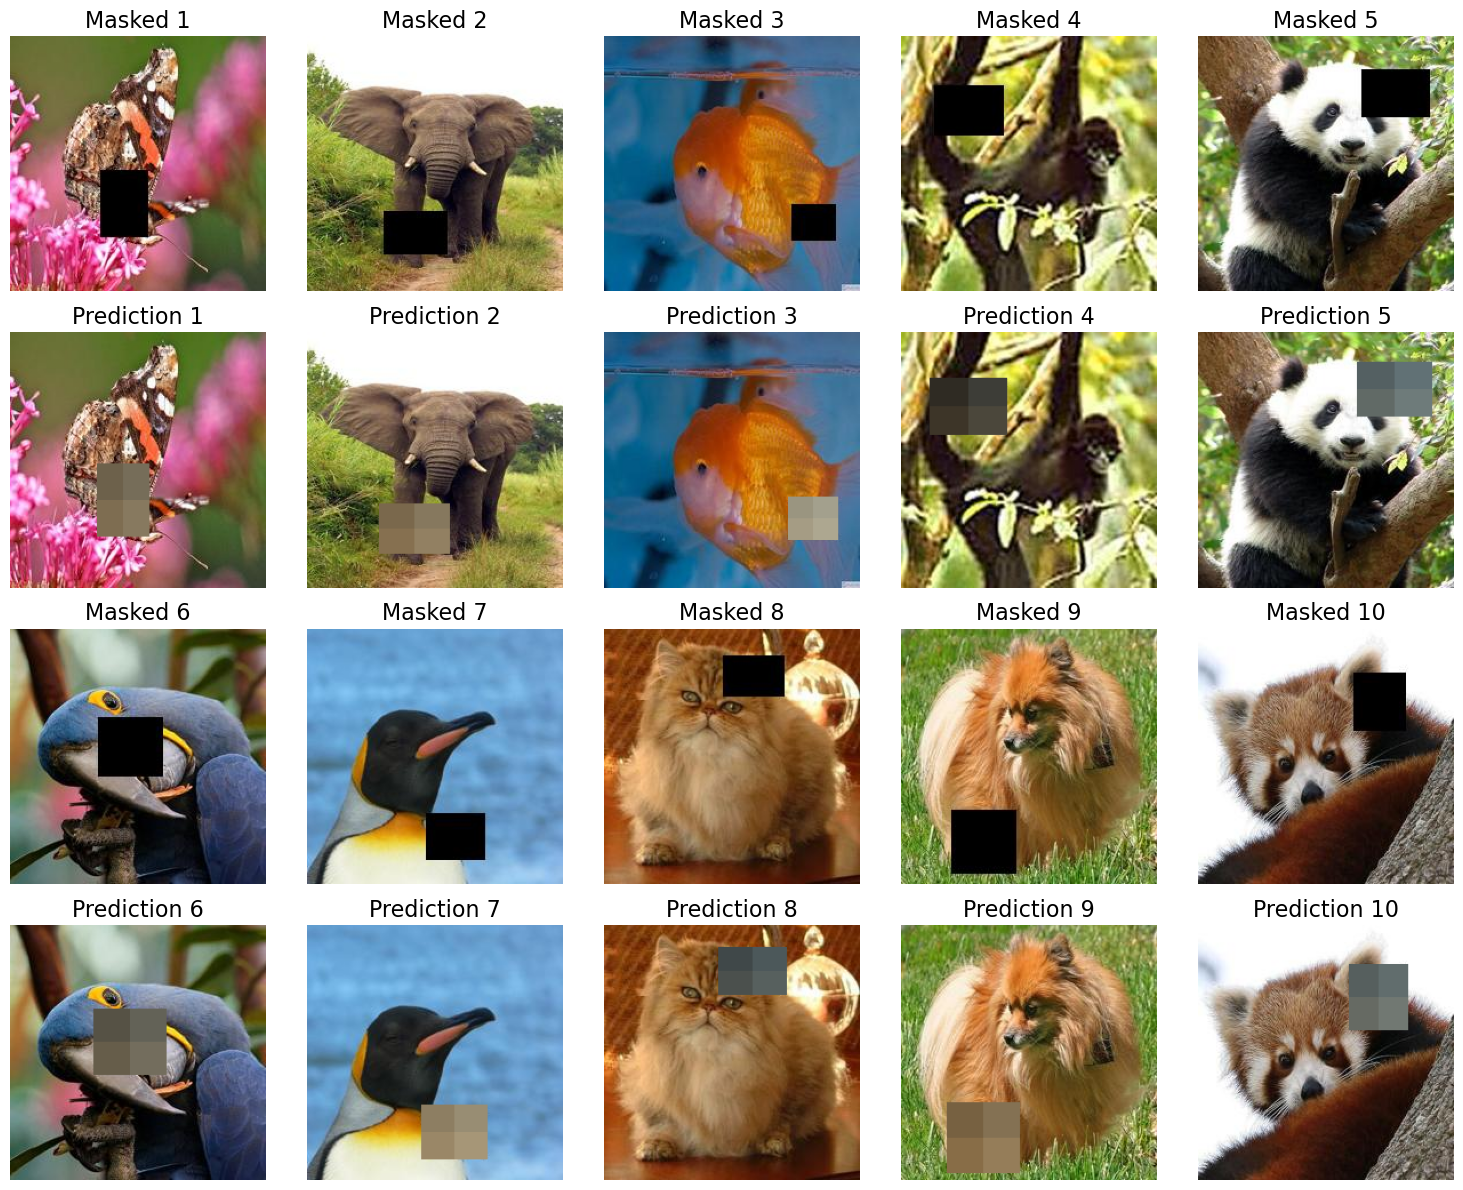

In [97]:
num_iterations = 150
learning_rate = 0.05

weights_r, weights_g, weights_b = train_regression_model(features, targets, num_iterations, learning_rate)

# Process test dataset
original_images, masked_images, reconstructed_images = process_test_data(
    test_dir, weights_r, weights_g, weights_b
)

# Convert reconstructed and test images back to [0, 255] range
unnormalized_reconstructed_images = [
    (reconstructed_image * 255.0).astype(np.float32) for reconstructed_image in reconstructed_images
]
unnormalized_test_images = [
    (test_image * 255.0).astype(np.float32) for test_image in original_images
]

# Initialize lists to store MSE and MAE for each image pair
mse_list = []
mae_list = []

# Calculate MSE and MAE for each image pair
for original, reconstructed in zip(unnormalized_test_images, unnormalized_reconstructed_images):
    mse, mae = evaluate_reconstruction(original, reconstructed)
    mse_list.append(mse)
    mae_list.append(mae)


# Compute average MSE and MAE across all image pairs
average_mse = np.mean(mse_list)
average_mae = np.mean(mae_list)

# Print the results
print(f"Linear Regression MSE: {average_mse:.4f}")
print(f"Linear Regression MAE: {average_mae:.4f}")


# Process reference images
masked_reference, reconstructed_reference = reconstruct_reference(
    reference_dir, weights_r, weights_g, weights_b
)

# Display results
display_results(masked_reference, reconstructed_reference)